# 5.1 Criação de Modelos de Machine Learning - Tunning

## Carregar dados tratados

In [3]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV

import joblib

In [ ]:

from sklearn.linear_model import LogisticRegression


In [5]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

In [6]:
def split_dados(df, test_size: float = 0.2):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=test_size, random_state=42)

    return (X_treino, X_teste, y_treino, y_teste)

In [7]:
def plot_confusion_matrix_heat(cf_matrix):
    cf_matrix.index.name = 'Atual'
    cf_matrix.columns.name = 'Predito'
    
    cf_nd_array = cf_matrix.to_numpy()
    cf_flatten = cf_nd_array.flatten()

    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_flatten]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_flatten / np.sum(cf_nd_array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print(cf_matrix.shape)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


In [8]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, y_prev, target_names=["Vender", "Comprar"])
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    plot_confusion_matrix_heat(cf_matrix)
    plt.show()
    metric = metrics.precision_score(y_teste, y_prev)
    print("Precision: ", metric)
    print("#" * 50)
    return metric

# ML modelo

In [9]:
def definir_modelo_ml() -> dict:
    return {
            "LogisticRegression": {'modelo_base': LogisticRegression(random_state=42), 'modelo_tunado': None},
            # "LogisticRegression_tun": {'modelo_base': LogisticRegression(random_state=42, warm_start=True, penalty="none", n_jobs=-1), 'modelo_tunado': None},
           }

In [ ]:
def definir_modelo_ml() -> dict:
    return dict(LogisticRegression={'modelo_base': LogisticRegression(random_state=42),
                                   'modelo_tunado': None})

In [10]:
def treinar_modelo_base(modelos, splited_dados):

    X_treino, _, y_treino, y_test = splited_dados

    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)
        # pred = modelo.predict(y_test)

        modelos[nome]['modelo_base'] = modelo
        # avaliar(y_test, pred, nome)
    
    return modelos

## Tunning do modelo

In [11]:
def scale_data(df):
    scaler = StandardScaler()
    tabela_auxiliar = df.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = df["decisao"]
    
    return tabela_auxiliar

In [12]:
def fit_tunning_rand_search_log_reg(X_treino, y_treino):
    print("Tunning randomized search Log Reg")

    # Create the random params

    param = {
             "solver": ["lbfgs"],
             "penalty": ["l2", "none"],
             "dual": [False],
             "tol": [0.0001],
             "C": [1.0],
             "fit_intercept": [True],
             'class_weight': [False, "balanced"],
             'multi_class': ["ovr", "auto"],
             'warm_start': [False, True],
             'random_state': [42, 2, None],
             'n_jobs': [-1],
            }

    print(param)

    rf_random = RandomizedSearchCV(estimator=LogisticRegression(max_iter=300),
                                   param_distributions=param,
                                   cv=10,
                                   verbose=0,
                                   scoring="average_precision",
                                   random_state=42,
                                   n_jobs=-1)
                        
    # Best params {'warm_start': True, 'tol': 0.0001, 'solver': 'lbfgs', 'random_state': 42, 'penalty': 'none', 'n_jobs': -1, 'multi_class': 'auto', 'fit_intercept': True, 'dual': False, 'class_weight': False, 'C': 1.0}
    # Best score 0.5669691646905763

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [13]:

def run_log_reg_tunning(df, splited_dados):

    X_treino, X_teste, y_treino, y_teste = splited_dados
    
    resultado_grid = fit_tunning_rand_search_log_reg(X_treino, y_treino)

    print("Ajuste Log Reg feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [14]:
def compare_tunning(df, modelos: dict, splited_dados):

    _, X_teste, _, y_teste = splited_dados

    recalls = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        recalls[nome + '_base'] =  avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        recalls[nome + '_tunned'] = avaliar(y_teste, prev, nome + '_tunado')
    
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
    ax.set(xlabel="Modelos", ylabel="Recall", title="Recall por Modelo")
    

In [15]:
def run_tunning_fit(df, modelos, splited_dados):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['LogisticRegression']['modelo_tunado'] = run_log_reg_tunning(df, splited_dados)

    return modelos


Tunning randomized search Log Reg
{'solver': ['lbfgs'], 'penalty': ['l2', 'none'], 'dual': [False], 'tol': [0.0001], 'C': [1.0], 'fit_intercept': [True], 'class_weight': [False, 'balanced'], 'multi_class': ['ovr', 'auto'], 'warm_start': [False, True], 'random_state': [42, 2, None], 'n_jobs': [-1]}
Ajuste Log Reg feito
Best params {'warm_start': True, 'tol': 0.0001, 'solver': 'lbfgs', 'random_state': 42, 'penalty': 'none', 'n_jobs': -1, 'multi_class': 'auto', 'fit_intercept': True, 'dual': False, 'class_weight': False, 'C': 1.0}
Best score 0.5669691646905763
LogisticRegression_base
Reporte teste
              precision    recall  f1-score   support

      Vender       0.57      0.57      0.57       186
     Comprar       0.57      0.57      0.57       185

    accuracy                           0.57       371
   macro avg       0.57      0.57      0.57       371
weighted avg       0.57      0.57      0.57       371

(2, 2)


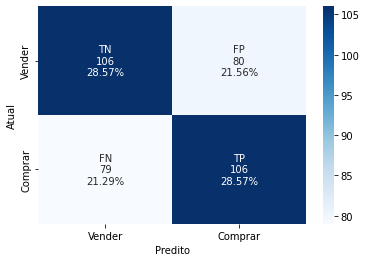

Precision:  0.5698924731182796
##################################################
LogisticRegression_tunado
Reporte teste
              precision    recall  f1-score   support

      Vender       0.57      0.59      0.58       186
     Comprar       0.58      0.56      0.57       185

    accuracy                           0.57       371
   macro avg       0.57      0.57      0.57       371
weighted avg       0.57      0.57      0.57       371

(2, 2)


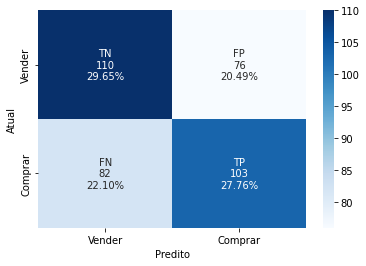

Precision:  0.5754189944134078
##################################################


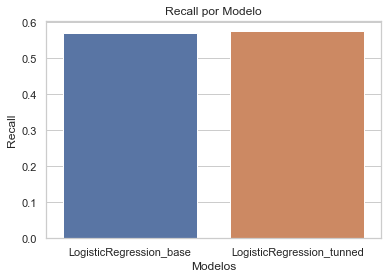

In [16]:
def main():

    df = carregar_joblib()

    modelo = definir_modelo_ml()

    splited_dados = split_dados(df)

    modelo = treinar_modelo_base(modelo, splited_dados)

    # df = scale_data(df)
    
    modelo = run_tunning_fit(df, modelo, splited_dados)

    compare_tunning(df, modelo, splited_dados)

    return df, modelo, splited_dados

df, modelos, splited_dados = main()